### Day 10 - Improving Conv2d performance
- 

In [ ]:
import pandas as pd
import numpy as np
from math import prod
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
from lovely_numpy import Lo
from lovely_tensors import monkey_patch; monkey_patch()
from torch import Tensor
from torch.nn.functional import conv2d

In [ ]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
cuda.init()

device = cuda.Device(0)

print(f"Cuda version: {".".join([str(i) for i in cuda.get_version()])}")
print(f"Device:\t{device.name()}")

Cuda version: 12.8.0
Device:	NVIDIA GeForce RTX 3080 Laptop GPU


In [ ]:
cu_file_naive="kernels/conv2d/conv2d_naive.cu"

In [ ]:
#|output: asis
#|echo: false

c_code = Path(cu_file_naive).read_text()
print(f'''

### [{cu_file_naive}](https://github.com/xl0/cuda-100/blob/master/nbs/{cu_file_naive})

The first implementation from the previous day

::: {{.sourceCode}}
```cpp
{c_code}
```
:::
''')



### [kernels/conv2d/conv2d_naive.cu](https://github.com/xl0/cuda-100/blob/master/nbs/kernels/conv2d/conv2d_naive.cu)

The first implementation from the previous day

::: {.sourceCode}
```cpp
#include <stdint.h>
#include <stdio.h>

#include "conv2d-helpers.h"

/* 2D convolution, with padding to valid shape. Channel-first */
__global__ void conv2d_pad(float *in,
                           float *out,
                           float *filter,
                           int h,
                           int w,
                           int in_channels,
                           int out_channels,
                           int filter_size /* Must be an odd number */,
                           float pad) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    int filter_r = (filter_size - 1) / 2;


    // In and Out data dimensions:
    // 0 - channel
    // 1 - height
    // 2 - width

    // Filter dimensions:
    // 0 - out channel

In [ ]:
cu_file_z_out="kernels/conv2d/conv2d-z-out.cu"

In [ ]:
#|output: asis
#|echo: false

c_code = Path(cu_file_z_out).read_text()
print(f'''

### [{cu_file_z_out}](https://github.com/xl0/cuda-100/blob/master/nbs/{cu_file_z_out})

This implementation uses separate blocks per output channel

::: {{.sourceCode}}
```cpp
{c_code}
```
:::
''')



### [kernels/conv2d/conv2d-z-out.cu](https://github.com/xl0/cuda-100/blob/master/nbs/kernels/conv2d/conv2d-z-out.cu)

This implementation uses separate blocks per output channel

::: {.sourceCode}
```cpp
#include <stdint.h>
#include <stdio.h>

#include "conv2d-helpers.h"

// This version uses the z grid dimensions for out channels
// This means each thread has to calculate only one output channel
__global__ void conv2d_pad_z_out(float *in,
                                 float *out,
                                 float *filter,
                                 int h,
                                 int w,
                                 int in_channels,
                                 int out_channels,
                                 int filter_size /* Must be an odd number */,
                                 float pad) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    int out_ch = blockIdx.z;

    int filter_r = (fil

In [ ]:
def benchmark_conv2d_pad(ctx, kernel, input, filter, pad, block_size, grid_size, repeat=10, warmup=True):
    # input, channel-first
    # - Channel
    # - Height
    # - Width
    assert len(input.shape) == 3

    # Filter shape should be
    # - Out channels
    # - In  channels
    # - Height
    # - Width
    assert len(filter.shape) == 4

    in_ch, h, w = input.shape
    out_ch, in_ch2, fh, fw = filter.shape

    assert fh == fw, f"Only square filters supported, got shape={filter.shape}"

    assert in_ch == in_ch2

    out_shape = (out_ch, h, w)

    gpu_input = cuda.mem_alloc_like(input)
    gpu_filter = cuda.mem_alloc_like(filter)

    out = np.empty(out_shape, dtype=np.float32)

    cuda.memcpy_htod(gpu_input, input)
    cuda.memcpy_htod(gpu_filter, filter)
    ctx.synchronize()

    timing=0
    for _ in range(repeat):
        start = cuda.Event()
        end = cuda.Event()

        gpu_out = cuda.mem_alloc_like(out)

        if warmup:
            kernel(gpu_input, gpu_out, gpu_filter,
                   np.int32(h),
                   np.int32(w),
                   np.int32(in_ch),
                   np.int32(out_ch),
                   np.int32(fh),
                   np.float32(pad),
                   grid=grid_size,
                   block=block_size)
            ctx.synchronize()

        start.record()
        kernel(gpu_input, gpu_out, gpu_filter,
               np.int32(h),
               np.int32(w),
               np.int32(in_ch),
               np.int32(out_ch),
               np.int32(fh),
               np.float32(pad),
               grid=grid_size,
               block=block_size)
        end.record()
        end.synchronize()

        timing += end.time_since(start)
    timing /= repeat

    cuda.memcpy_dtoh(out, gpu_out)
    return out, timing;

### Test matrix
Sample some random shapes (not too big though) for input/output/channels/filter sizes

In [ ]:
in_chan_range = [1, 3, 8, 32, 128, 512]
out_chan_range = [1, 4, 8, 32, 128, 512]

filter_size = [1, 3, 5, 9]

img_size_range = [64, 128, 256, 512, 1024]

# Let's sample from the available options.
n_samples = 50


# Generate all possible combinations
combinations = []
for in_ch in in_chan_range:
    for out_ch in out_chan_range:
        for fs in filter_size:
            for img_size in img_size_range:
                    n = in_ch * out_ch * img_size * img_size

                    # Skip combinatoins that are too large
                    if n < 1024*1024*32*32:
                        combinations.append((in_ch, out_ch, fs, img_size))

n_samples = min(n_samples, len(combinations))
sampled_combinations = np.random.choice(len(combinations), size=n_samples, replace=False)
test_cases = [combinations[i] for i in sampled_combinations]

### Run the tests

In [ ]:
import warn_options

In [ ]:
tile_width = 32

data = []

# test_cases = [(3, 4, 32,32)]

ctx = device.make_context()
try:
    mod_naive = SourceModule(
        Path(cu_file_naive).read_text(),
        options=warn_options.warn_options + ["-DACCUM_DTYPE=float"],
        include_dirs=[str(Path(cu_file_naive).parent.absolute())]
        )

    mod_z_out = SourceModule(
        Path(cu_file_z_out).read_text(),
        options=warn_options.warn_options + ["-DACCUM_DTYPE=float"],
        include_dirs=[str(Path(cu_file_z_out).parent.absolute())])


    kernels = {
        "conv2d_pad": mod_naive.get_function("conv2d_pad"),
        "conv2d_pad_z_out":mod_z_out.get_function("conv2d_pad_z_out"),
    }

    for tc in tqdm(test_cases):
        ch_in, ch_out, fs, pixels = tc

        array_in = np.random.randn(ch_in, pixels, pixels).astype(np.float32)
        filter = np.random.randn(ch_out, ch_in, fs, fs).astype(np.float32)

        torch_out = conv2d(Tensor(array_in), Tensor(filter), padding="same")

        timings = {}

        for kernel_name, kernel in kernels.items():

            block_size = (tile_width,tile_width,1)
            grid_size = (
                ((pixels + tile_width - 1) // tile_width),
                ((pixels + tile_width - 1) // tile_width),
                ch_out if kernel_name == "conv2d_pad_z_out" else 1
            )


            out, timing = benchmark_conv2d_pad(ctx, kernel, array_in, filter, 0, block_size, grid_size, repeat=5, warmup=True)

            if np.isclose(out, torch_out).mean() < 0.8:
                print("### Result mismatch ###")
                print(f"Kernel: {kernel_name}")
                print(f"Input shape: {array_in.shape}")
                print(f"Filter shape: {filter.shape}")
                print(f"Result shape: {(filter.shape[0], array_in.shape[1], array_in.shape[2])}")
                print(f"Grid size: {grid_size}")
                print(f"Block size: {block_size}")
                print(f"Total threads: {prod((*grid_size, *block_size))}")

            timings[kernel_name] = timing

        data.append({
            'in_ch': ch_in,
            'out_ch': ch_out,
            'filter_size': fs,
            'img_size': pixels,
            # 'kernel': kernel_name,
        } | timings)


finally:
    ctx.pop()
    ctx.detach()

results = pd.DataFrame(data)

  0%|          | 0/50 [00:00<?, ?it/s]

### Test results

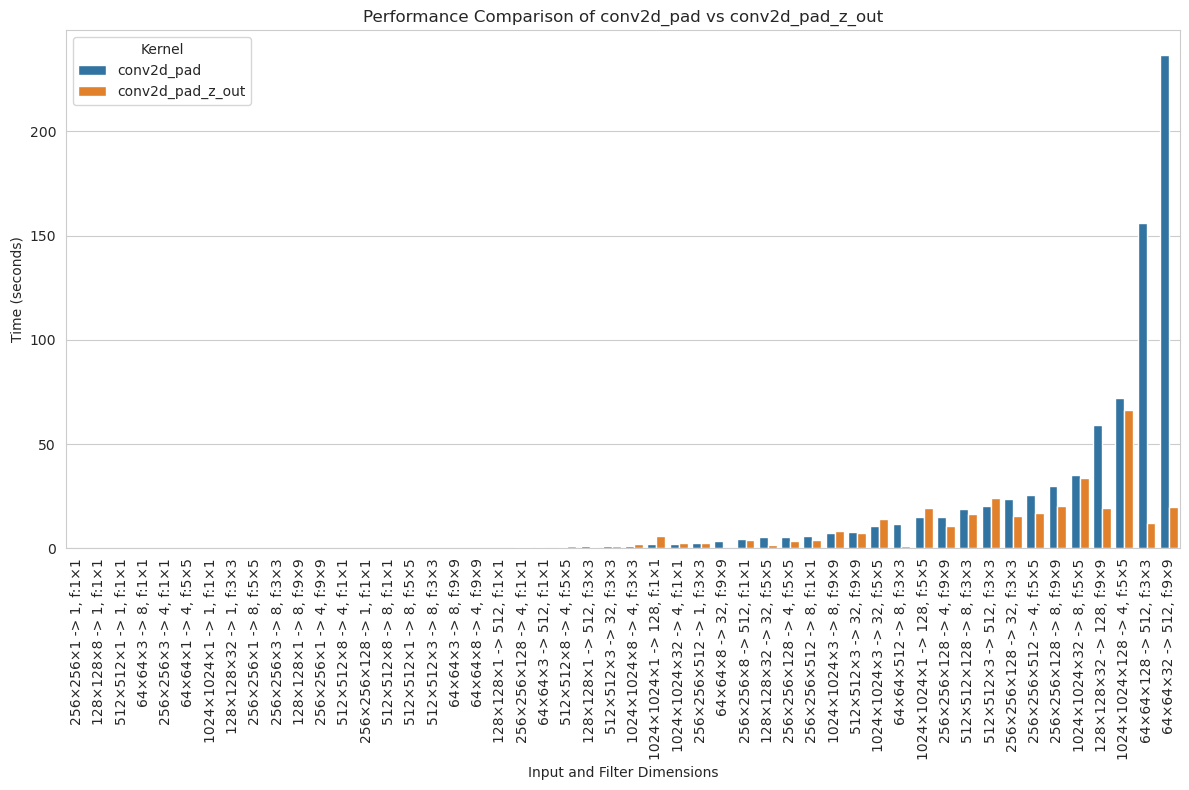

,in_ch,out_ch,filter_size,img_size,conv2d_pad,conv2d_pad_z_out,dimensions
49,1,1,1,256,0.019046,0.019046,"256×256×1 -> 1, f:1×1"
8,8,1,1,128,0.021709,0.020890,"128×128×8 -> 1, f:1×1"
45,1,1,1,512,0.022528,0.020275,"512×512×1 -> 1, f:1×1"
27,3,8,1,64,0.026419,0.014336,"64×64×3 -> 8, f:1×1"
16,3,4,1,256,0.031744,0.033382,"256×256×3 -> 4, f:1×1"
17,1,4,5,64,0.035840,0.022118,"64×64×1 -> 4, f:5×5"
38,1,1,1,1024,0.056525,0.055706,"1024×1024×1 -> 1, f:1×1"
40,32,1,3,128,0.087450,0.084378,"128×128×32 -> 1, f:3×3"
4,1,8,5,256,0.095232,0.082739,"256×256×1 -> 8, f:5×5"
37,3,8,3,256,0.107520,0.096256,"256×256×3 -> 8, f:3×3"


In [ ]:
# Sort by conv2d_pad timing
results_sorted = results.sort_values(by='conv2d_pad')

# Create a plot comparing the two kernels
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create labels for x-axis that include dimensions
results_sorted['dimensions'] = results_sorted.apply(
    lambda row: f"{int(row['img_size'])}×{int(row['img_size'])}×{int(row['in_ch'])} -> {int(row['out_ch'])}, f:{int(row['filter_size'])}×{int(row['filter_size'])}",
    axis=1
)

# Melt the dataframe to get it in the right format for seaborn
melted_results = pd.melt(
    results_sorted,
    id_vars=['in_ch', 'out_ch', 'filter_size', 'img_size', 'dimensions'],
    value_vars=['conv2d_pad', 'conv2d_pad_z_out'],
    var_name='kernel',
    value_name='time'
)

# Create a barplot with dimensions as x-ticks
ax = sns.barplot(x='dimensions', y='time', hue='kernel', data=melted_results)

# Add labels
plt.xlabel('Input and Filter Dimensions')
plt.ylabel('Time (seconds)')
plt.title('Performance Comparison of conv2d_pad vs conv2d_pad_z_out')
plt.xticks(rotation=90)

# Add a legend
plt.legend(title='Kernel')

# Show the plot
plt.tight_layout()
plt.show()

# Also display the sorted results table
results_sorted